# Train example notebook

This notebook is used to implement the training of a neural network for classification of `Cloud`, `Edge`, `Good` images. <br> It is advisable to use this notebook to get practice and debug your code. To speed up the execution, once you are ready, you should move to a scripted version.

## 1. - Imports

Select `CUDA_VISIBLE_DEVICES` to the `Graphics Proceesing Unit (GPU)` index that you want to use to enable the use of GPU.

In [51]:
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="0" # GPU index

Enabling autoreload of different packages.

In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
import torch 
import sys
sys.path.insert(1, os.path.join("..", "data"))
sys.path.insert(1, os.path.join("..", "utils"))
from data_utils import Dataset
from plot_utils import plot_image
from torch.utils.data import DataLoader

## 2. - Datasets

### 2.1 - Creating datasets

Now we read the images from the target directory `path_data`. Set `path_data` to the directory containing the `Cloud`, `Edge`, `Good` subfolders.  Moreover, it will automatically split the total dataset into the train, cross validation and test splits by using a pseudo-random splitting algorithm. You can reproduce the split by specifying the variable `seed`. **NB**:
- The train split contains 70% of the whole images.
- The valid splits contains 15% of the whole images.
- The test splits contains 15% of the whole images.
<br>**YOU MUST NOT CHANGE THE TEST SPLIT SIZE!!!**

In [54]:
# Path to the data folder (update the variable to your path).
path_data=os.path.join("..", "data")
# Seed value
seed=23

<img src="utilities/images/danger_icon.png" style="margin:auto"/>

**N.B** Make sure to have created a dataset split into the three directories `Cloud`, and `Good`, `Edge`. Otherwise, the next cell will **fail!** <br>


In [55]:
dataset=Dataset(path_data=path_data, seed=seed)
dataset.read_data()

Parsing class: Cloud: 141it [00:13, 10.75it/s]
Parsing class: Edge: 97it [00:07, 12.89it/s]
Parsing class: Good: 66it [00:05, 11.06it/s]


**Hint:** before proceeding, make sure that your `Edge`,`Cloud`, and `Good` samples are well enough among the `train`, `valid`,`test` splits. To print datasets statistics, run the next line.  Remember that the number of images in the different splits is distributed as described above. <br> If you are not happy with the data distribution, you can update the seed used and create a new dataset by rerunning the cell above. 

In [56]:
dataset.get_statistics()

train  valid  test
cloud    104     20    17
edge      66     16    15
good      42     10    14

### 2.2. - Create data loaders.

The next lines will create a dataloader. A data loader is used to break the dataset into batches of a size `batch_size`. <br> This is useful to ensure that your dataset will fit into your memory and to create a "stochastic" implementation of gradient descent. <br> For more information, please, check: [data loader](https://www.educative.io/answers/what-is-pytorch-dataloader).<br>
Specify `batch_size` (**Hint**: use powers of 2. Typical values are between 8 and 64).

In [57]:
batch_size=32

In [58]:
# Train loader
train_loader = DataLoader(dataset.get_split("train"), batch_size=batch_size, pin_memory=False, shuffle=True)
# Cross validation data loader
valid_loader = DataLoader(dataset.get_split("valid"), batch_size=batch_size, pin_memory=False, shuffle=True)
# Test data loader
test_loader = DataLoader(dataset.get_split("test"), batch_size=batch_size, pin_memory=False, shuffle=True)

## 3 - Training

Now, it is your turn! Add your code below to load a Neural Network model, select optimizers, learning rate and perform training. <br>
Good luck!

In [59]:
classes = ('cloud', 'edge', 'good')

In [60]:
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid 
import torch.nn.functional as F 
import numpy as np
import matplotlib.pyplot as plt

def resize_tensor_images(images, size=(256, 256)):
    # Resize the batch of images
    return F.interpolate(images, size=size, mode='bilinear', align_corners=False)

def normalize_individual_image(image):
    # Calculate the mean and std for each channel of the image
    mean = image.mean(dim=[1, 2])
    std = image.std(dim=[1, 2])

    # Ensure std is not zero to avoid division by zero
    std = std.clamp(min=1e-9)

    # Normalize the image
    normalized_image = (image - mean[:, None, None]) / std[:, None, None]
    return normalized_image
    
def tensor_to_numpy(tensor):
    # Rescale the tensor to 0-1 range
    tensor = tensor - tensor.min()
    tensor = tensor / tensor.max()
    # Move the tensor to CPU if it's on GPU
    tensor = tensor.cpu()

    # Convert to numpy and transpose from CxHxW to HxWxC for visualization
    numpy_image = tensor.numpy()
    numpy_image = np.transpose(numpy_image, (1, 2, 0))

    return numpy_image
normalized_batches_TRL = []
normalized_batches_VAL = []
for batch in train_loader:
    images, labels = batch

    resized_images_TRL = resize_tensor_images(images)

    # Normalize each image in the batch
    # normalized_images_TRL = torch.stack([normalize_individual_image(img) for img in resized_images_TRL])
    normalized_images_TRL = resized_images_TRL / 256
    normalized_batches_TRL.append((normalized_images_TRL, labels))

for batch in valid_loader:
    images, labels = batch

    resized_images_VAL = resize_tensor_images(images)

    # Normalize each image in the batch
    # normalized_images_VAL = torch.stack([normalize_individual_image(img) for img in resized_images_VAL])
    normalized_images_VAL = resized_images_VAL /256 
    normalized_batches_VAL.append((normalized_images_VAL, labels))


In [61]:


import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2)
        self.NS1 = 16*64*64
        self.NS2 = 86
        self.NS3 = 16
        self.NS4 = 3

        self.fc1 = nn.Linear(self.NS1, self.NS2)  
        self.fc2 = nn.Linear(self.NS2, self.NS3)
        self.fc3 = nn.Linear(self.NS3, self.NS4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()




In [62]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [63]:
n_epochs = 500

In [64]:

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(normalized_batches_TRL, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        print(labels)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

tensor([2, 2, 1, 2, 0, 2, 1, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0, 1, 0,
        1, 1, 0, 0, 0, 1, 2, 0])
tensor([0, 2, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 2, 0, 1, 1, 1, 2, 1, 1, 0, 1,
        2, 2, 0, 0, 0, 0, 0, 1])
tensor([2, 0, 1, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 1,
        0, 1, 1, 0, 2, 1, 1, 0])
tensor([0, 0, 0, 1, 2, 0, 1, 2, 0, 0, 2, 0, 2, 0, 1, 1, 2, 0, 2, 0, 2, 1, 2, 2,
        1, 1, 0, 0, 0, 0, 0, 2])
tensor([2, 0, 2, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0, 1, 1, 2, 1, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 1, 2, 0, 0])
tensor([1, 0, 0, 0, 0, 2, 1, 1, 2, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 2, 2,
        1, 2, 1, 0, 1, 0, 1, 2])
tensor([1, 0, 2, 0, 1, 0, 0, 2, 2, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 2])
tensor([2, 2, 1, 2, 0, 2, 1, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0, 1, 0,
        1, 1, 0, 0, 0, 1, 2, 0])
tensor([0, 2, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 2, 0, 1, 1, 1, 2, 1, 1, 0, 1,
        2, 2, 0, 0, 0, 0, 0, 1])
tensor([2, 0, 1, 2, 0, 1, 0

In [65]:


txt = './e{}_n{}-{}-{}_b{}_s{}.pth'.format(n_epochs, net.NS1, net.NS2, net.NS3, batch_size, seed,)
PATH = txt
# PATH = './test1.pth'
torch.save(net.state_dict(), PATH)

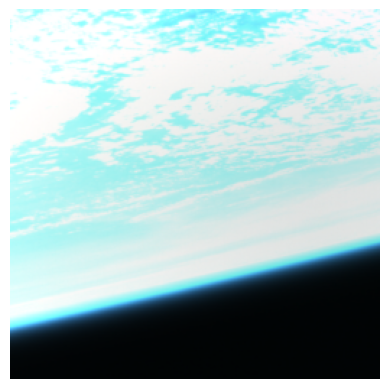

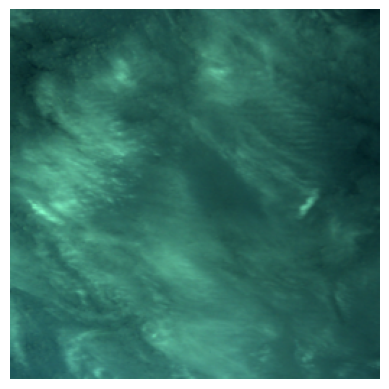

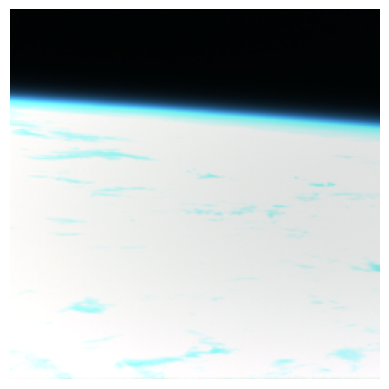

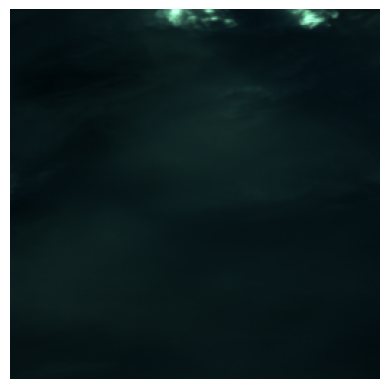

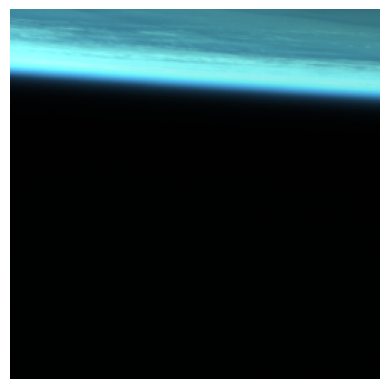

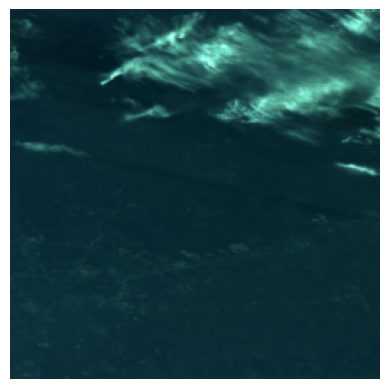

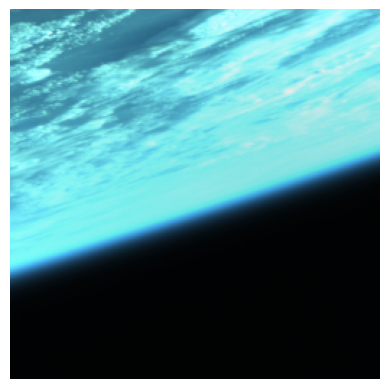

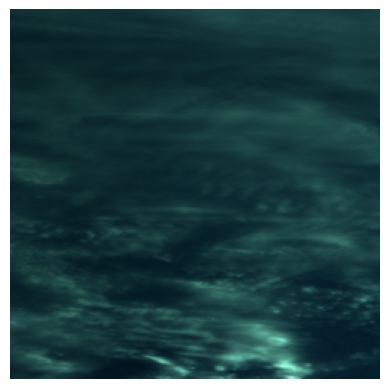

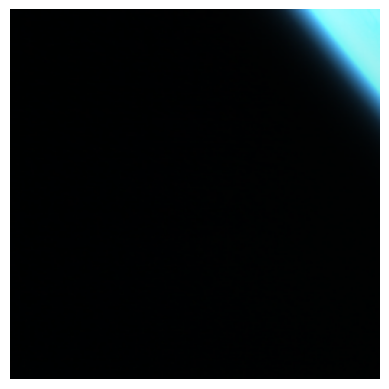

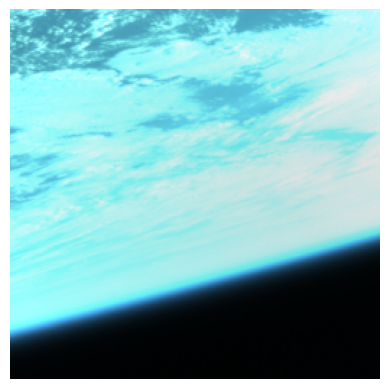

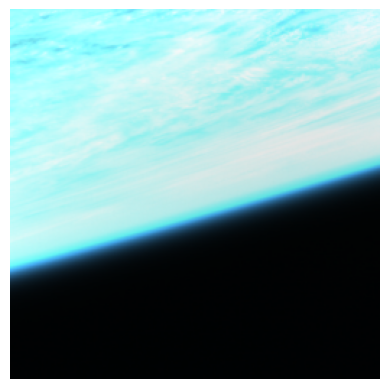

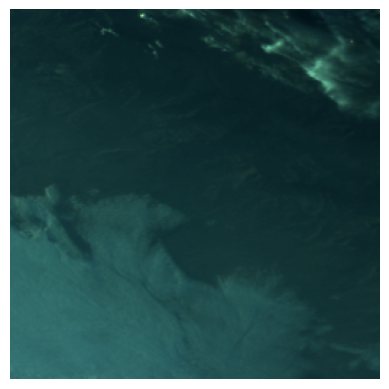

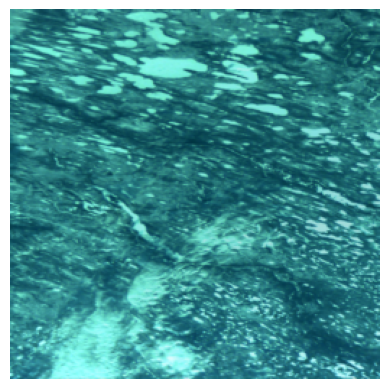

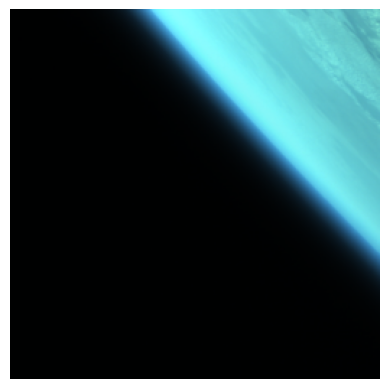

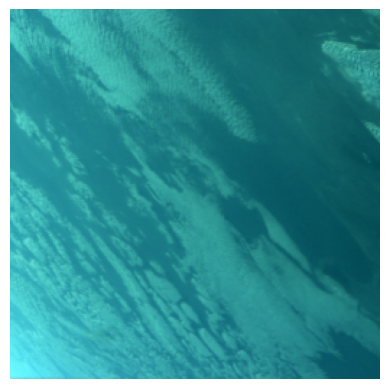

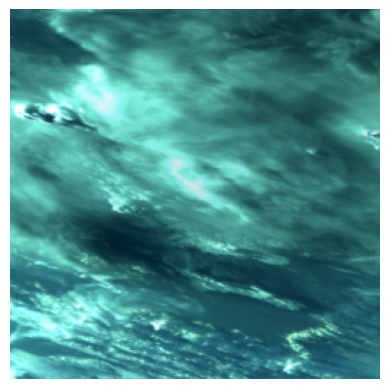

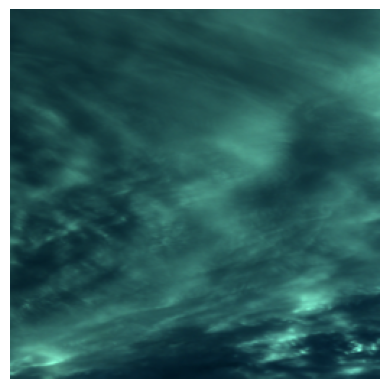

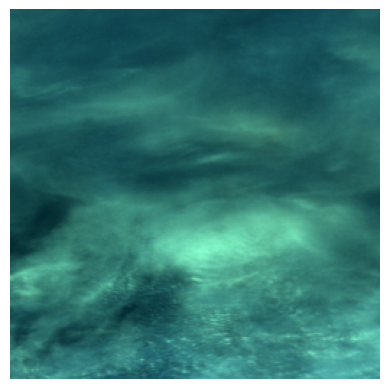

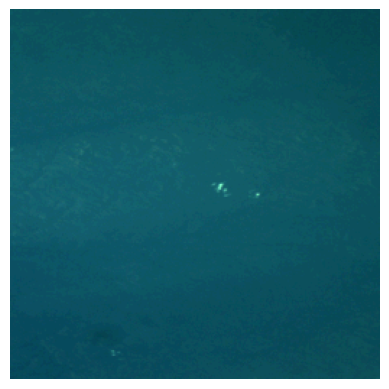

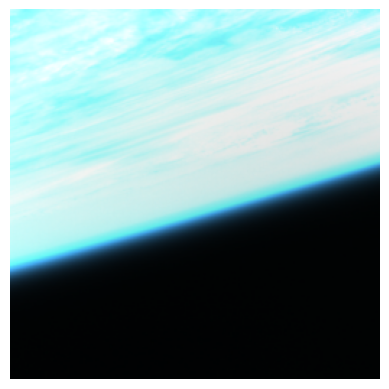

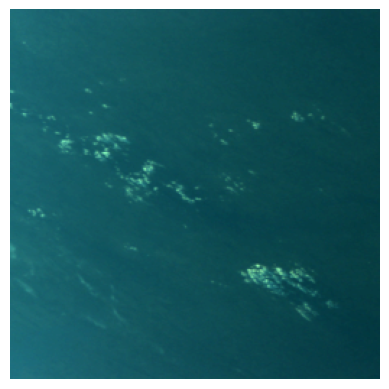

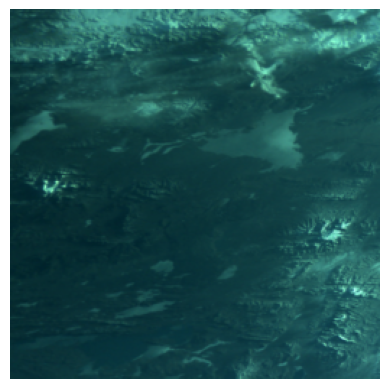

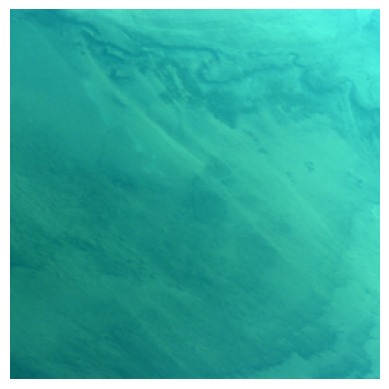

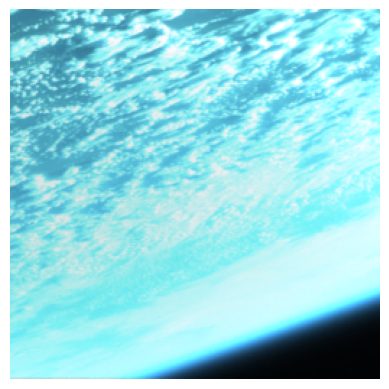

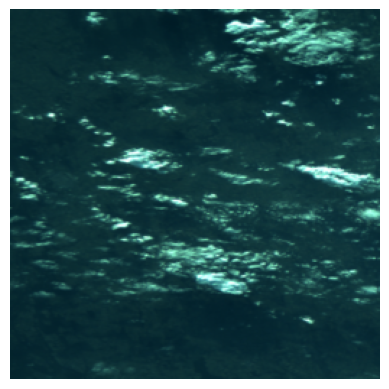

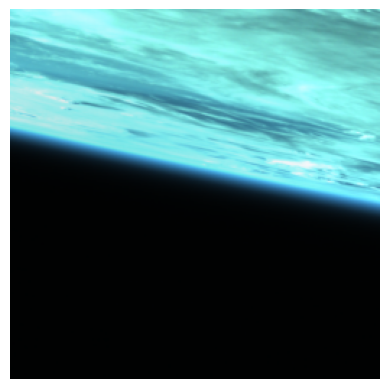

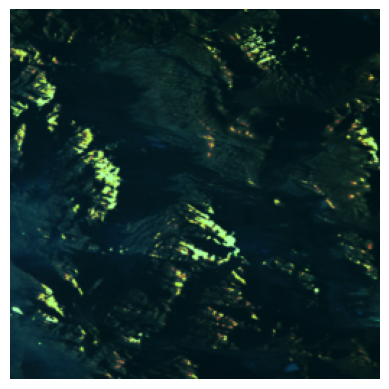

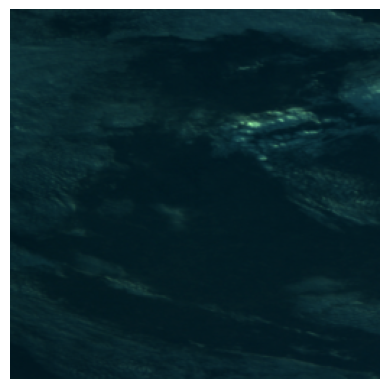

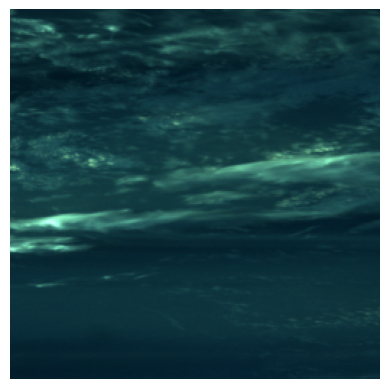

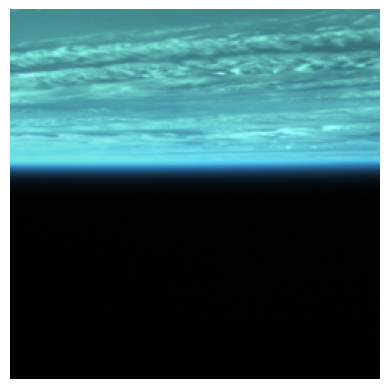

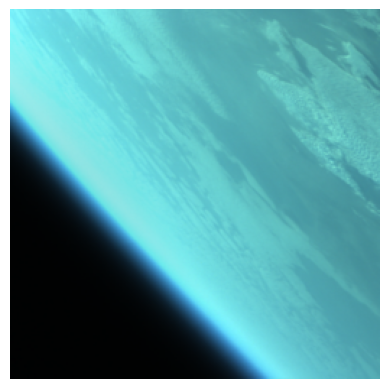

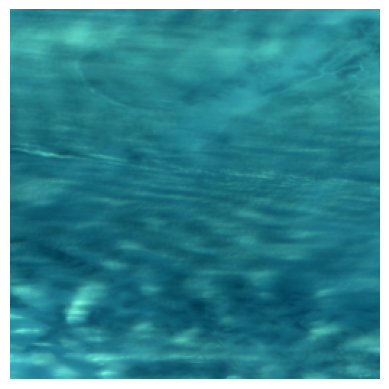

In [66]:
dataiter = iter(normalized_batches_VAL)
images, labels = next(dataiter)

# print images
for i in range(len(images)):
    first_image_tensor = images[i]

    # Convert the tensor to a NumPy array
    first_image_numpy = tensor_to_numpy(first_image_tensor)

    # Display the image
    plt.imshow(first_image_numpy)
    plt.axis('off')  # Remove axis markers
    plt.show()


In [67]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [68]:
outputs = net(images)
print(outputs)

tensor([[-6.3843e+01,  8.0759e+01, -1.3451e+01],
        [-3.2432e+00, -9.8366e+00,  3.3171e+00],
        [ 7.9647e+00,  4.4967e+00, -6.7641e+01],
        [-7.5926e-01, -7.7229e+00,  5.5598e+00],
        [-9.5207e+00,  4.8125e+01, -2.9427e+01],
        [ 1.7778e+01, -1.3265e+01, -7.4871e+00],
        [-8.9985e+00,  5.8284e+01, -3.7383e+01],
        [ 1.2416e+01, -2.0973e+01, -2.8690e+00],
        [-3.0298e+00,  8.1497e+00, -3.0044e+00],
        [-4.8100e+01,  5.9418e+01, -8.3564e+00],
        [-1.7537e+01,  8.1150e+01, -4.9519e+01],
        [ 1.0649e+00, -4.0965e+00, -6.0376e+00],
        [ 2.4145e+01, -4.2388e+01, -8.9047e+00],
        [-1.1032e+01,  2.8190e+01, -1.0291e+01],
        [ 1.3911e+01, -2.8571e+01, -1.3560e+01],
        [ 9.9900e+00, -4.3575e+01,  1.0554e+01],
        [ 1.2335e+01, -2.0055e+01, -2.5762e+00],
        [ 5.3486e+00, -1.4218e+01,  1.8849e+00],
        [ 2.5690e+00, -1.0258e+01,  3.8935e+00],
        [-1.6403e+01,  8.6910e+01, -5.4238e+01],
        [ 2.1771e+00

In [69]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(32)))

Predicted:  edge  good  cloud good  edge  cloud edge  cloud edge  edge  edge  cloud cloud edge  cloud good  cloud cloud good  edge  good  cloud cloud edge  good  edge  good  cloud good  edge  edge  good 
